In [1]:
# Why is this not just a standard feature of every notebook?
%load_ext autoreload
%autoreload 2

In [2]:
from kpl_layers import polynomial
import torch
import matplotlib.pyplot as plt
import math

In [4]:
psnn = polynomial.PolySplineLayer(1,3,10,1)
print(psnn)

PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=3, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)


In [5]:
print(psnn.state_dict())

OrderedDict([('poly_coeffs.0.weight', tensor([[ 0.3566, -0.0867,  0.1269],
        [ 0.2158,  0.1533, -0.0679],
        [-0.2285, -0.5033, -0.0385],
        [ 0.2211, -0.0337, -0.4867],
        [ 0.2016, -0.1523,  0.1897],
        [-0.1999, -0.4794,  0.2190],
        [ 0.3601,  0.4712, -0.2052],
        [ 0.3696,  0.1714,  0.0036],
        [-0.4788,  0.3678,  0.1003],
        [ 0.2579, -0.0356,  0.4894]])), ('poly_coeffs.0.bias', tensor([ 0.4431,  0.2109, -0.3403,  0.0232, -0.3759,  0.5472,  0.4142, -0.2252,
         0.2658,  0.3186])), ('attention.0.1.weight', tensor([[ 0.2347,  0.1255],
        [ 0.6274, -0.3460],
        [ 0.4091, -0.1747],
        [-0.2330, -0.5727],
        [-0.2591,  0.5312],
        [ 0.5559, -0.4352],
        [-0.3972, -0.0512],
        [ 0.6943,  0.3580],
        [ 0.1722, -0.7022],
        [ 0.2161,  0.4453]])), ('attention.0.1.bias', tensor([ 0.5193, -0.3685, -0.5564,  0.4243, -0.1873,  0.2269,  0.5171, -0.2242,
         0.1772, -0.2280]))])


In [6]:
n_parameters = 0
for p in psnn.parameters():
    print('{}: {} ({}->{})'.format(p.name,type(p),p.size(),torch.numel(p)))
    n_parameters += torch.numel(p)
print(f'Total parameters: {n_parameters}')

None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10, 3])->30)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10])->10)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10, 2])->20)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10])->10)
Total parameters: 70


In [7]:
# Create some random data to train on
n_train = 100000
x_train = 3*math.tau*torch.rand(n_train,1)
y_train = torch.cos(x_train)
ds_train = torch.utils.data.TensorDataset(x_train,y_train)
loader_train = torch.utils.data.DataLoader(ds_train,batch_size=100)

n_test = 1000
x_test = 3*math.tau*torch.rand(n_test,1)
y_test = torch.cos(x_test)
ds_test = torch.utils.data.TensorDataset(x_test,y_test)
loader_test = torch.utils.data.DataLoader(ds_test,batch_size=100)

In [8]:
# Configure the network for training
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(psnn.parameters(),lr=1e-4)

In [9]:
# Taken from the pytorch tutorial code
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(loader_train, psnn, loss, optimizer)
    test_loop(loader_test, psnn, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 171314.953125  [    0/100000]
loss: 209726.953125  [20000/100000]
loss: 125077.796875  [40000/100000]
loss: 4102.394043  [60000/100000]
loss: 708.416260  [80000/100000]
Test Error: 
 Avg loss: 159.050266 

Epoch 2
-------------------------------
loss: 145.617935  [    0/100000]
loss: 58.384468  [20000/100000]
loss: 29.336416  [40000/100000]
loss: 22.601429  [60000/100000]
loss: 24.619225  [80000/100000]
Test Error: 
 Avg loss: 17.862097 

Epoch 3
-------------------------------
loss: 19.818260  [    0/100000]
loss: 6.155478  [20000/100000]
loss: 3.182144  [40000/100000]
loss: 2.690624  [60000/100000]
loss: 1.781525  [80000/100000]
Test Error: 
 Avg loss: 1.532604 

Epoch 4
-------------------------------
loss: 1.486519  [    0/100000]
loss: 1.200932  [20000/100000]
loss: 1.020461  [40000/100000]
loss: 0.924998  [60000/100000]
loss: 0.765687  [80000/100000]
Test Error: 
 Avg loss: 0.686024 

Epoch 5
-------------------------------
loss: 0.68

In [11]:
print(psnn.state_dict())

OrderedDict([('poly_coeffs.0.weight', tensor([[ 0.0114, -0.2764, -0.0361],
        [ 1.8691,  1.8825,  1.0946],
        [ 1.4249,  1.2259,  1.1240],
        [-0.7241, -0.4441, -1.1621],
        [ 0.2208, -0.0941,  0.2406],
        [-0.0094, -0.4869, -0.0388],
        [ 0.6229, -0.2006, -1.2509],
        [ 0.2822,  0.1133, -0.0078],
        [ 1.1628,  2.1586,  1.4531],
        [ 0.8616,  0.6530,  1.1480]])), ('poly_coeffs.0.bias', tensor([-0.0058,  1.7774,  1.2262,  0.1674, -0.4457,  1.2814,  2.4543, -0.3662,
         1.9225,  0.8804])), ('attention.0.1.weight', tensor([[ 0.4590,  0.4517],
        [ 0.6274, -0.3460],
        [ 0.4091, -0.1747],
        [ 0.9982, -0.6316],
        [-0.2193,  0.4899],
        [ 1.4591,  0.2752],
        [ 0.5923,  0.1863],
        [ 0.7821,  0.4508],
        [-1.1507, -1.7554],
        [ 0.6979,  0.3590]])), ('attention.0.1.bias', tensor([ 0.6889, -0.3685, -0.5564,  2.4287, -0.0943,  0.9686,  1.9401, -0.2496,
         1.0350,  0.5124]))])


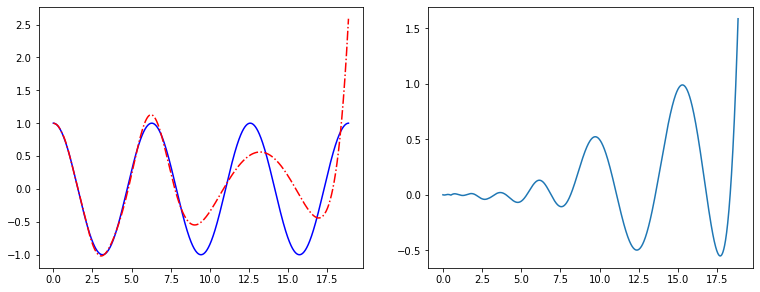

In [12]:
x = torch.arange(0,3*math.tau,0.01)
y_true = torch.cos(x)
with torch.no_grad():
    y_pred = psnn(x[:,None])[:,0]
plt.figure(figsize=(12.8,4.8))
plt.subplot(121)
plt.plot(x,y_true,'b',x,y_pred,'r-.')
plt.subplot(122)
plt.plot(x,y_pred-y_true)

In [13]:
with torch.no_grad():
    attn = psnn.attention[0](x[:,None])
    poly = psnn.poly_coeffs[0](psnn.monomial_layer(x[:,None]))

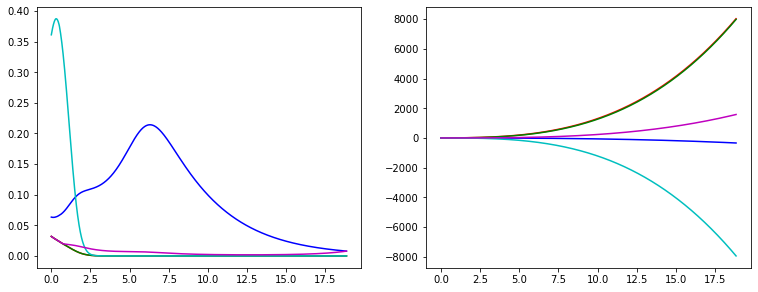

In [14]:
plt.figure(figsize=(12.8,4.8))
plt.subplot(121)
plt.plot(x,attn[:,0],'b',x,attn[:,1],'r',x,attn[:,2],'g',x,attn[:,3],'c',x,attn[:,4],'m')
plt.subplot(122)
plt.plot(x,poly[:,0],'b',x,poly[:,1],'r',x,poly[:,2],'g',x,poly[:,3],'c',x,poly[:,4],'m');

In [15]:
y_true.shape

torch.Size([1885])